# Computational data processing

🎯 **Goal**: Clean the experimental data for the distance traveled by cells.

---

## Context

Even though we obtain the BC when simulations are run, it is useful to look into the results to get a better understanding of what they represent.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import io as sio
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../optimization')
import optimization

## Visualizing the BC coefficient

The BC quantifies the similarity between two histograms. Thus, we can plot both the experimental and computational data as histograms to visualize if they overlap. We will also be outputting the BC. Since this is an example, we will be using the control data for the 96 hours/2.5 mg/mL experiment, but this code could be used to generate histograms for every condition.

In [2]:
# Read the experimental and computational data

def read_results_into_df(output_path):
    variables = ['position_y']
    all_cells = []
    replicates = list(output_path.glob('output*'))
    number_of_output_files = len(list(replicates[0].glob('output*.xml')))

    for replicate in replicates[:3]:
        for timestep in range(number_of_output_files):
            cell_data = physipy.get_cell_data(timestep, replicate, variables)
            cell_df = pd.DataFrame(cell_data)
            cell_df['day'] = timestep
            cell_df['replicate'] = replicate
            all_cells.append(cell_df)

    cells_df = pd.concat([df for df in all_cells])

    return cells_df

def read_experimental_data(experimental_conditions):
    # Store data from all conditions in a dict
    data = {}

    for condition in experimental_conditions:
        # Load file
        mat_path = DATA_PATH / f'{FILE_STEM}{condition}.mat'
        mat_file = sio.loadmat(mat_path)
        distance_to_monolayer = mat_file['glob_dist2mono']

        # Format the data from four columns to two columns
        # One column will contain the distances and the other will contain the corresponding day
        distance_to_monolayer = pd.melt(pd.DataFrame(distance_to_monolayer))
        distance_to_monolayer.rename(columns={'variable': 'day', 'value': 'distance'},
                                     inplace=True)
        # Drop the NaN rows
        distance_to_monolayer = distance_to_monolayer.dropna()
        # Convert day column from 0 index notation
        distance_to_monolayer['day'] = distance_to_monolayer['day'] + 1
        distance_to_monolayer['distance'] = distance_to_monolayer['distance']
        distance_to_monolayer['condition'] = condition

        data[condition] = distance_to_monolayer
        
    data_df = pd.concat(data)

    return data_df

def fix_distance_baseline(data_df):
    """Computes new distance values based on the predicted monolayer location"""
    
    data_df['fixed_distance'] = np.NaN

    # Select each condition and print info on minimum values
    for condition in data_df.condition.unique():
        condition_indexes = list(data_df[data_df['condition'] == condition].index)
        condition_df = data_df.loc[condition_indexes]
        minimum_values = condition_df.groupby('day')['distance'].describe()['min']
        baseline_value = minimum_values.mean()
        data_df.loc[condition_indexes, 'fixed_distance'] = \
            data_df.loc[condition_indexes, 'distance'] - baseline_value

    data_df.loc[data_df['fixed_distance'] < 0, 'fixed_distance'] = 0
    
    return data_df

FILE_STEM = 'multichip_data_'
DATA_PATH = Path('./raw-data')

chemotaxis_conditions = ['control']
control_df = read_experimental_data(chemotaxis_conditions)
control_df = fix_distance_baseline(control_df)

cells = pd.read_csv('saved_dfs/chemo96/control_0.csv')

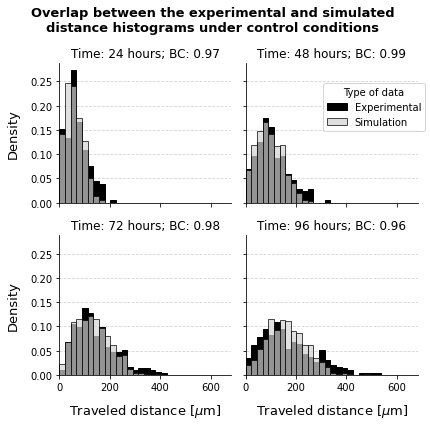

In [3]:
distance_range = 650
number_of_bins = 30
bins = np.linspace(0, distance_range, number_of_bins)

# Plot figure (each column represents a day)
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    distance_at_day = control_df[control_df['day'] == i+1]['fixed_distance']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist_exp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins,
                                  label='Experimental' if i==0 else None,
                                  facecolor='black',
                                  edgecolor='black')
    
    distance_at_day = cells[cells['timestep'] == i+1]['position_y']
    weights = np.ones_like(distance_at_day) / len(distance_at_day)
    hist_comp, *metadata = ax.hist(distance_at_day, weights=weights, bins=bins, 
                                    label='Simulation' if i==0 else None,
                                    facecolor='lightgrey', alpha=0.7, edgecolor='black')
    
    similarity_matrix = [np.sqrt(comp_bin * exp_bin)
                             for comp_bin, exp_bin
                             in zip(hist_comp, hist_exp)]
    
    bc = np.sum(similarity_matrix)
    
    ax.set_xlim(0, None)
    ax.set_title(f'Time: {(i+1)*24} hours; BC: {round(bc, 2)}')
    if i > 1:
        ax.set_xlabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
    if (i == 0) | (i == 2):
        ax.set_ylabel('Density', labelpad=10, fontsize=13)
    
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
sns.despine()

plt.suptitle('Overlap between the experimental and simulated\ndistance histograms under control conditions', 
             fontweight='bold',
             fontsize=13)

fig.tight_layout()

fig.legend(title='Type of data', loc=(0.75, 0.69))

## Comparing simulated and experimental boxplots
### 216 hours

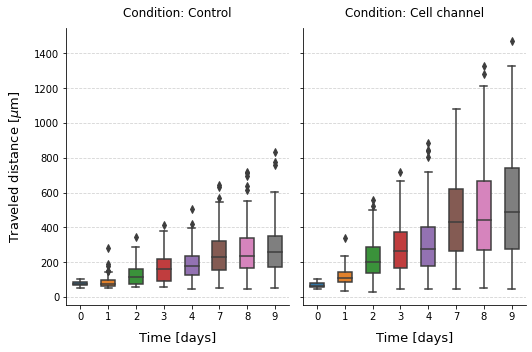

In [4]:
# Store data from all conditions in a dict
data = {}
chemotaxis_conditions = ['control_216h', 'factor_216h']
conditions_labels = ['Control', 'Opposite chamber']

for condition in chemotaxis_conditions:
    # Load file
    mat_path = DATA_PATH / f'{FILE_STEM}{condition}.mat'
    mat_file = sio.loadmat(mat_path)
    distance_to_monolayer = mat_file['glob_dist2mono']
    
    # Format the data from four columns to two columns
    # One column will contain the distances and the other will contain the corresponding day
    distance_to_monolayer = pd.melt(pd.DataFrame(distance_to_monolayer))
    distance_to_monolayer.rename(columns={'variable': 'day', 'value': 'distance'}, 
                                 inplace=True)
    # Drop the NaN rows
    distance_to_monolayer = distance_to_monolayer.dropna()
    # Convert day column from 0 index notation
    distance_to_monolayer['day'] = distance_to_monolayer['day'] + 1
    distance_to_monolayer['distance'] = distance_to_monolayer['distance'] 
    distance_to_monolayer['condition'] = condition
    
    data[condition] = distance_to_monolayer

# Plot distance boxplots
chemotaxis_df = pd.concat([df for df in data.values()])

# Fix the times at which the information was stored
convert_days = {old: new 
                for old, new in zip(range(1, 9), [0, 1, 2, 3, 4, 7, 8, 9])}  

chemotaxis_df['day'] = chemotaxis_df['day'].map(convert_days)

fig = sns.catplot(data=chemotaxis_df, x='day', y='distance', col='condition', 
                  kind='box', width=0.5, aspect=0.75)

# Figure style
for ax, condition in zip(fig.axes.flatten(), ['Control', 'Cell channel', 'Opposite channel']):
    ax.set_title(f'Condition: {condition}', y=1.02)
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')
    
fig.set_xlabels('Time [days]', labelpad=10, fontsize=13)
fig.set_ylabels('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)
plt.tight_layout()

In [5]:
chemotaxis_df['fixed_distance'] = np.NaN

# Select each condition and print info on minimum values
for condition in chemotaxis_conditions:
    condition_indexes = list(chemotaxis_df[chemotaxis_df['condition'] == condition].index)
    condition_df = chemotaxis_df.loc[condition_indexes]
    minimum_values = condition_df.groupby('day')['distance'].describe()['min']
    baseline_value = minimum_values.mean()
    chemotaxis_df.loc[condition_indexes, 'fixed_distance'] = chemotaxis_df.loc[condition_indexes, 'distance'] - baseline_value

chemotaxis_df.loc[chemotaxis_df['fixed_distance'] < 0, 'fixed_distance'] = 0

chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

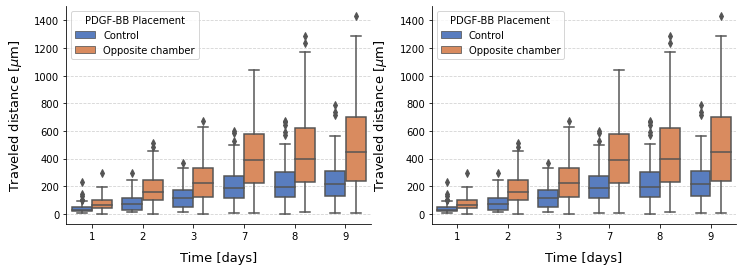

In [6]:
chemotaxis_df = chemotaxis_df[chemotaxis_df['day'] != 0]
chemotaxis_df = chemotaxis_df[chemotaxis_df['day'] != 4]

sns.set_palette('muted', 3)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, ax in enumerate(axes):
    sns.boxplot(data=chemotaxis_df, x='day', y='fixed_distance', hue='condition', ax=ax)

    # Figure style

    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')

    #ax.set_title(f'Distance traveled by cells in the presence of\nPDGF-BB chemotactic gradients (9 days study)', y=1.02, 
    #             fontsize=13, fontweight='bold')

    ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
    ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

    ax.legend(title='PDGF-BB Placement')

sns.despine()

In [7]:
simulation_cells = []

for i in range(3):
    cells = pd.read_csv(f'saved_dfs/chemo216/control_{i}.csv')
    simulation_cells.append(cells)
    
final_cells = pd.concat(simulation_cells)
final_cells['type_of_data'] = 'Computational'
final_cells['condition'] = 'Control'
final_cells = final_cells.drop('replicate', axis=1)
final_cells = final_cells[final_cells['timestep'] != 0]
final_cells = final_cells[final_cells['timestep'] != 4]
final_cells = final_cells[final_cells['timestep'] != 5]
final_cells = final_cells[final_cells['timestep'] != 6]
final_cells = final_cells.rename(columns={'position_y': 'fixed_distance', 'timestep':'day'})

simulation_cells = []

for i in range(3):
    cells = pd.read_csv(f'saved_dfs/chemo216/opposite_{i}.csv')
    simulation_cells.append(cells)
    
opposite_cells = pd.concat(simulation_cells)
opposite_cells['type_of_data'] = 'Computational'
opposite_cells['condition'] = 'Opposite chamber'
opposite_cells = opposite_cells.drop('replicate', axis=1)
opposite_cells = opposite_cells[opposite_cells['timestep'] != 0]
opposite_cells = opposite_cells[opposite_cells['timestep'] != 4]
opposite_cells = opposite_cells[opposite_cells['timestep'] != 5]
opposite_cells = opposite_cells[opposite_cells['timestep'] != 6]
opposite_cells = opposite_cells.rename(columns={'position_y': 'fixed_distance', 'timestep':'day'})

exp_cells = chemotaxis_df.copy()
exp_cells = exp_cells.drop('distance', axis=1)
exp_cells['type_of_data'] = 'Experimental'

all_cells = pd.concat([exp_cells, final_cells, opposite_cells], sort=True)
all_cells

,condition,day,fixed_distance,type_of_data
301,Control,1,26.565000,Experimental
302,Control,1,20.125000,Experimental
303,Control,1,13.685000,Experimental
304,Control,1,13.685000,Experimental
305,Control,1,20.125000,Experimental
...,...,...,...,...
16576,Opposite chamber,9,632.199093,Computational
16577,Opposite chamber,9,285.298292,Computational
16578,Opposite chamber,9,360.444735,Computational
16579,Opposite chamber,9,574.256564,Computational


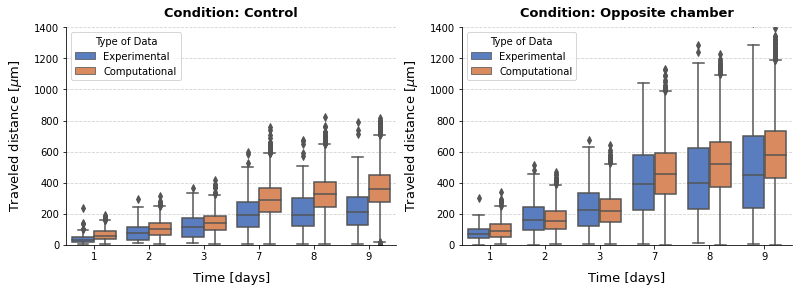

In [8]:
sns.set_palette('muted', 3)
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
conditions = ['Control', 'Opposite chamber']

for i, ax in enumerate(axes):
    sns.boxplot(data=all_cells[all_cells['condition'] == conditions[i]], x='day', y='fixed_distance', 
                hue='type_of_data', ax=ax)

    # Figure style
    
    ax.set_ylim(0, 1400)
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')

    ax.set_title(f'Condition: {conditions[i]}', y=1.02, 
                 fontsize=13, fontweight='bold')

    ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)

    ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

    ax.legend(title='Type of Data', loc='upper left')

sns.despine()

### 4mg/mL

In [9]:
# Store data from all conditions in a dict
data = {}
chemotaxis_conditions = ['4mg_control', '4mg_factor']
conditions_labels = ['Control', 'Opposite channel']

for condition in chemotaxis_conditions:
    # Load file
    mat_path = DATA_PATH / f'{FILE_STEM}{condition}.mat'
    mat_file = sio.loadmat(mat_path)
    distance_to_monolayer = mat_file['glob_dist2mono']
    
    # Format the data from four columns to two columns
    # One column will contain the distances and the other will contain the corresponding day
    distance_to_monolayer = pd.melt(pd.DataFrame(distance_to_monolayer))
    distance_to_monolayer.rename(columns={'variable': 'day', 'value': 'distance'}, 
                                 inplace=True)
    # Drop the NaN rows
    distance_to_monolayer = distance_to_monolayer.dropna()
    # Convert day column from 0 index notation
    distance_to_monolayer['day'] = distance_to_monolayer['day'] + 1
    distance_to_monolayer['distance'] = distance_to_monolayer['distance'] 
    distance_to_monolayer['condition'] = condition
    
    data[condition] = distance_to_monolayer

# Plot distance boxplots
chemotaxis_df = pd.concat([df for df in data.values()])

chemotaxis_df['fixed_distance'] = np.NaN

# Select each condition and print info on minimum values
for condition in chemotaxis_conditions:
    condition_indexes = list(chemotaxis_df[chemotaxis_df['condition'] == condition].index)
    condition_df = chemotaxis_df.loc[condition_indexes]
    minimum_values = condition_df.groupby('day')['distance'].describe()['min']
    baseline_value = minimum_values.mean()
    chemotaxis_df.loc[condition_indexes, 'fixed_distance'] = chemotaxis_df.loc[condition_indexes, 'distance'] - baseline_value

chemotaxis_df.loc[chemotaxis_df['fixed_distance'] < 0, 'fixed_distance'] = 0

chemotaxis_df['condition'] = chemotaxis_df['condition'].map({condition: label 
                                                            for condition, label
                                                            in zip(chemotaxis_conditions, conditions_labels)})

In [10]:
simulation_cells = []

for i in range(3):
    cells = pd.read_csv(f'saved_dfs/4mg/control_{i}.csv')
    simulation_cells.append(cells)
    
final_cells = pd.concat(simulation_cells)
final_cells['type_of_data'] = 'Computational'
final_cells['condition'] = 'Control'
final_cells = final_cells.drop('replicate', axis=1)
final_cells = final_cells[final_cells['timestep'] != 0]
final_cells = final_cells.rename(columns={'position_y': 'fixed_distance', 'timestep':'day'})

simulation_cells = []

for i in range(3):
    cells = pd.read_csv(f'saved_dfs/4mg/opposite_{i}.csv')
    simulation_cells.append(cells)
    
opposite_cells = pd.concat(simulation_cells)
opposite_cells['type_of_data'] = 'Computational'
opposite_cells['condition'] = 'Opposite channel'
opposite_cells = opposite_cells.drop('replicate', axis=1)
opposite_cells = opposite_cells[opposite_cells['timestep'] != 0]
opposite_cells = opposite_cells.rename(columns={'position_y': 'fixed_distance', 'timestep':'day'})

exp_cells = chemotaxis_df.copy()
exp_cells = exp_cells.drop('distance', axis=1)
exp_cells['type_of_data'] = 'Experimental'

all_cells = pd.concat([exp_cells, final_cells, opposite_cells], sort=True)
all_cells

,condition,day,fixed_distance,type_of_data
0,Control,1,116.322500,Experimental
1,Control,1,151.742500,Experimental
2,Control,1,82.512500,Experimental
3,Control,1,50.312500,Experimental
4,Control,1,39.042500,Experimental
...,...,...,...,...
2472,Opposite channel,4,313.676718,Computational
2473,Opposite channel,4,247.602390,Computational
2474,Opposite channel,4,304.485322,Computational
2475,Opposite channel,4,275.983187,Computational


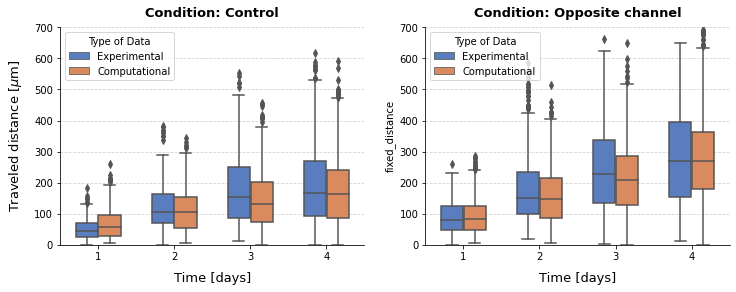

In [11]:
sns.set_palette('muted', 3)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
conditions = ['Control', 'Opposite channel']

for i, ax in enumerate(axes):
    sns.boxplot(data=all_cells[all_cells['condition'] == conditions[i]], x='day', y='fixed_distance', 
                hue='type_of_data', ax=ax, width=0.6)

    # Figure style
    ax.set_ylim(0, 700)
    ax.set_axisbelow(True)
    ax.grid(axis='y', c='lightgrey', linestyle='dashed')

    ax.set_title(f'Condition: {conditions[i]}', y=1.02, 
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Time [days]', labelpad=10, fontsize=13)
    if i==0:
        ax.set_ylabel('Traveled distance [$\mu$m]', labelpad=10, fontsize=13)

    ax.legend(title='Type of Data',  loc='upper left')

sns.despine()